# Notebook setup

In [1]:
import bw2data as bd
import bw2calc as bc
import bw2analyzer as ba
import bw2io as bi
import numpy as np
from scipy import sparse

In [4]:
import bw2data as bd
import bw2io as bi

PROJECT_NAME = "ecoinvent-3.10-cutoff"

bi.restore_project_directory(
    fp='/etc/data/ecoinvent-3.10-cutoff-bw25.tar.gz',
    project_name=PROJECT_NAME,
    overwrite_existing=True
)
bd.projects.set_current(PROJECT_NAME)

Restoring project backup archive - this could take a few minutes...


In [ ]:
lca = bc.LCA({bd.Database('ecoinvent-3.10-cutoff').random(): 1})
lca.lci()

This notebook assumes you already have a project with ecoinvent.

In [ ]:
if "USEEIO-1.1" not in bd.databases:
    bi.install_project("USEEIO-1.1", overwrite_existing=True)

In [ ]:
bd.projects.set_current("USEEIO-1.1")

In [ ]:
useeio = bd.Database("USEEIO-1.1")

In [ ]:
bd.databases

In [ ]:
bd.methods

# Contribution analysis

Before we dive in to `bw2analyzer`, we can actually do the basic contribution analysis easily by ourselves. All we need is to sum one axis of the `lca.characterized_inventory` matrix, sort the values and indices, and then retrieve the metadata for the indices with the highest values.

In [ ]:
our_act = useeio.random()

while our_act['type'] != 'product':
    our_act = useeio.random()

our_fu = {our_act: 1}

In [ ]:
our_act

In [5]:
bd.databases

Databases dictionary with 2 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff

In [8]:
lca = bc.LCA({bd.Database('ecoinvent-3.10-cutoff').random(): 1})
lca.lci()

Let's look at activities. In this case, we need to sum the rows (stressors or biosphere flows), which are the first axis. As Python is 0-indexed, we use `axis=0`:

In [ ]:
lca.characterized_inventory.shape

In [ ]:
by_activity = np.array(lca.characterized_inventory.sum(axis=0))
by_activity.shape

We then need to sort the values. As some may be large, but negative, we sort by the absolute value.

There are tricks to do this very quickly in numpy, but we can also be simple:

In [ ]:
sorted_values = sorted([(abs(value), value, index) for index, value in enumerate(by_activity[0, :])], reverse=True)

In [ ]:
sorted_values[:5]

Then we need to relate these **matrix** indices to something useful. We do this by going backwards, not from database IDs to matrix indices, but matrix indices to database IDs:

In [ ]:
for _, value, index in sorted_values[:5]:
    print(value, bd.get_activity(lca.dicts.activity.reversed[index]))

We can also get this information with `bw2analyzer`:

In [ ]:
ba.ContributionAnalysis().annotated_top_processes(lca)[:5]

The returned format here is `(LCIA score, amount in supply array, activity metadata)`.

Similary, we can look at the emissions:

In [ ]:
ba.ContributionAnalysis().annotated_top_emissions(lca)[:5]

In [ ]:
ba.__version__

In [ ]:
%debug

# Miscellaneous functions

## Graphing the technosphere matrix

In [14]:
for score, id_ in ba.page_rank.PageRank(bd.Database('ecoinvent-3.10-cutoff')).calculate():
    print(score, bd.get_node(id=id_))

0.014195987488616786 'market for transport, freight, lorry, unspecified' (ton kilometer, RER, None)
0.008960013699914648 'market for transport, freight, lorry, unspecified' (ton kilometer, RoW, None)
0.006389122423352004 'market for transport, freight train' (ton kilometer, CH, None)
0.00635657309125894 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None)
0.005939074663789274 'market for diesel, burned in building machine' (megajoule, GLO, None)
0.005895011386346661 'market for transport, freight, lorry, unspecified' (ton kilometer, ZA, None)
0.005644663042678249 'market for transport, freight, lorry, unspecified' (ton kilometer, BR, None)
0.005642688520184755 'market for sulfur hexafluoride, liquid' (kilogram, RoW, None)
0.005639280819607212 'market for transmission network, electricity, medium voltage' (kilometer, GLO, None)
0.00523787071683565 'market group for transport, freight train' (ton kilometer, GLO, None)
0.005080566191292015 'diesel, burned i

In [9]:
from bw2analyzer.matrix_grapher import SparseMatrixGrapher 

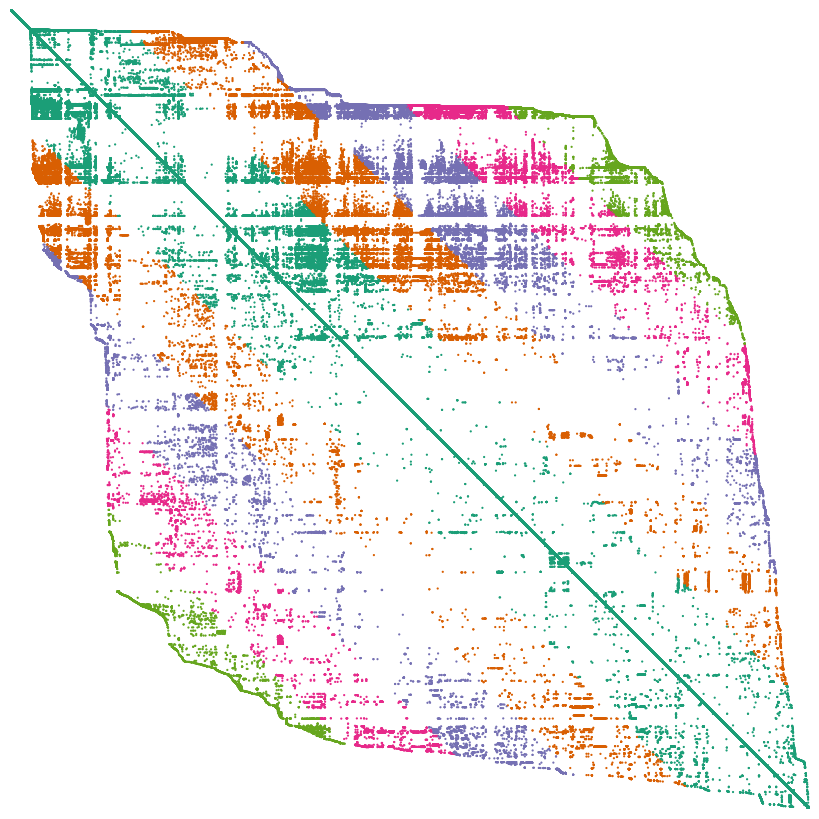

In [10]:
smg = SparseMatrixGrapher(lca.technosphere_matrix).ordered_graph(width=8, height=8)

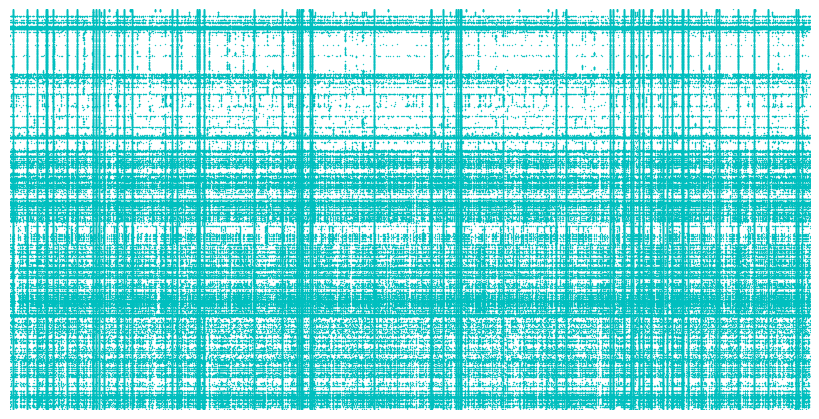

In [16]:
smg = SparseMatrixGrapher(lca.biosphere_matrix).graph(width=8, height=4)

This isn't so interesting for an IO table, but gets cooler for process databases with lots of empty space. We can simulate that:

In [ ]:
def shrink_sparse_matrix(matrix, fill_rate=0.025):
    m = matrix.tocoo()
    indices = np.random.randint(0, m.nnz, size=round(m.nnz * fill_rate))
    return sparse.csr_matrix((m.data[indices], (m.row[indices], m.col[indices])), shape=m.shape)

In [ ]:
smg = SparseMatrixGrapher(shrink_sparse_matrix(lca.technosphere_matrix, 0.05)).ordered_graph(width=8, height=8)

## Economic analysis

Do the rich activities have all the impact in this world?

In [ ]:
from bw2analyzer.econ import gini_coefficient, herfindahl_index, concentration_ratio, theil_index

In [ ]:
income = lca.characterized_inventory.data

In [ ]:
gini_coefficient(income), herfindahl_index(income), concentration_ratio(income), theil_index(income)

# Traversing the supply chain

There is an industrial-strength class in `bw2calc` called `GraphTraversal`, but for quick analysis we can use the following:

In [ ]:
ba.print_recursive_supply_chain(our_act, max_level=1)

Unfortunately, this notebook uses only free data, and the USEEIO uses `activities` and `products`, and this function assumes only activities so it isn't so helpful in this case...

In the above function, you can play with the following default arguments:

* amount=1,
* max_level=2,
* cutoff=0,
* file_obj=None,
* tab_character="  ",
* level=0,

Similarly, we can traverse the *characterized* inventory.

In [ ]:
ba.print_recursive_calculation(our_act, ('Impact Potential', 'GCC'))

Same thing here...